### __LightGBMの使い方__

- `'metric'`: 評価指標 [一覧](https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric-parameters)

#### __準備__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.datasets import load_breast_cancer, load_iris
import lightgbm as lgb

In [2]:
# LightGBMでCross Valdiationを行う

def lightgbm_cv(
    X: pd.DataFrame, # 学習データ
    y: pd.Series, # 学習データ
    X_test: pd.DataFrame, # テストデータ
    metric_name: str, # 評価指標
    params: dict, # LightGBMのパラメータ
    folds: int = 5, # fold数
    seed: int = 42, # シード値
    num_boost_round: int = 1000, # イテレーション関数
    stopping_rounds: int = 10, # アーリーストッピングの限界値
    stratified: bool = False, # StratifiedKFoldの有無
):
    if stratified:
        kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    else:
        kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    y_preds = []
    valid_scores, results, models = [], [], []

    for fold, (train_indices, valid_indices) in enumerate(kf.split(X, y)):
        X_train, X_valid = X.iloc[train_indices], X.iloc[valid_indices]
        y_train, y_valid = y.iloc[train_indices], y.iloc[valid_indices]

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

        result = {}
        model = lgb.train(
            params=params,
            train_set=lgb_train, # 学習データ
            valid_sets=[lgb_train, lgb_valid], # 検証データ
            valid_names=['train', 'valid'], # 学習経過で表示する名称
            num_boost_round=num_boost_round, # イテレーションの回数
            verbose_eval=False, # 出力を抑える
            callbacks=[
                lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=False), # アーリーストッピング
                lgb.callback.record_evaluation(result) # ログの記録
            ],
        )
        results.append(result)
        models.append(model)        

        score = result["valid"][metric_name][-1]
        valid_scores.append(score)
        print(f'Fold: {fold+1}  {metric_name.upper()}: {score}')

        # 推論
        y_preds.append(model.predict(X_test).tolist())

    cv_score = np.mean(valid_scores)
    print(f'CV: {np.mean(cv_score)}')

    y_pred = np.mean(y_preds, axis=0)
    return y_pred, results, models

#### __回帰__

変更点

- `METRIC_NAME = 'rmse'`

- `'objective': 'regression'`

In [3]:
# 評価指標
METRIC_NAME = 'rmse'

# パラメータ
FOLDS = 5
SEED = 42
params = {
    'objective': 'regression', # 回帰
    'metric': METRIC_NAME, # 評価指標
    'seed': 42,
    'num_leaves': 63,
    'learning_rate': 0.01,  # 学習率
    'feature_fraction': 0.8,
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
}

# データ
train = pd.read_csv('sample_data/california_housing_train.csv')
X_test = pd.read_csv('sample_data/california_housing_test.csv')
X = train.drop(columns='median_house_value')
y = train['median_house_value']

y_pred, results, models = lightgbm_cv(X, y, X_test, metric_name=METRIC_NAME, params=params, folds=FOLDS, seed=SEED)

Fold: 1  RMSE: 45819.07987045218
Fold: 2  RMSE: 45191.96855901596
Fold: 3  RMSE: 44976.875599406434
Fold: 4  RMSE: 44207.50959121845
Fold: 5  RMSE: 46506.702687754674
CV: 45340.427261569544


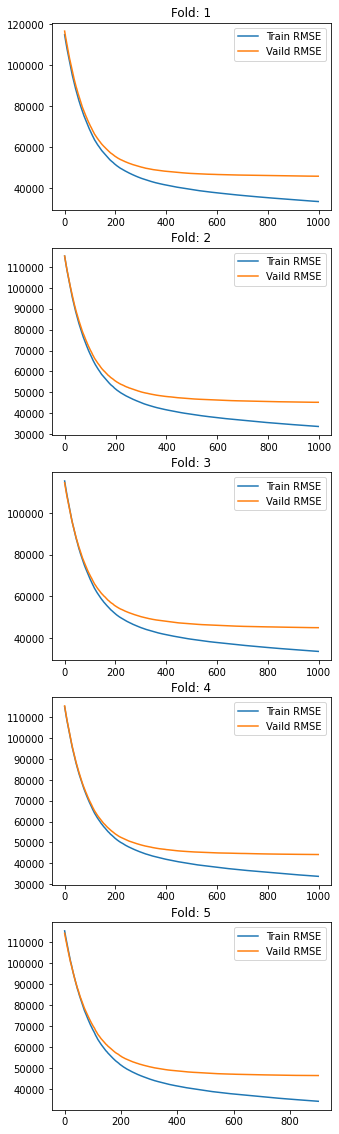

In [4]:
# fold毎に学習曲線を表示
plt.figure(figsize=(5, FOLDS*4))
for fold in range(FOLDS):
    plt.subplot(FOLDS, 1, fold+1)
    plt.plot(results[fold]['train'][METRIC_NAME], label=f"Train {METRIC_NAME.upper()}")
    plt.plot(results[fold]['valid'][METRIC_NAME], label=f"Vaild {METRIC_NAME.upper()}")
    plt.title(f'Fold: {fold+1}')
    plt.legend()
plt.show()

In [5]:
# 特徴量の重要度
importance = pd.DataFrame(np.mean([models[i].feature_importance(importance_type='gain') for i in range(FOLDS)], axis=0))
importance.index = X.columns
importance.columns = ['importance']
importance = importance.sort_values('importance', ascending=False)
importance

,importance
median_income,3.264151e+15
longitude,1.315784e+15
latitude,1.238697e+15
housing_median_age,3.398282e+14
population,3.029256e+14
total_rooms,1.720914e+14
total_bedrooms,1.615871e+14
households,1.477423e+14


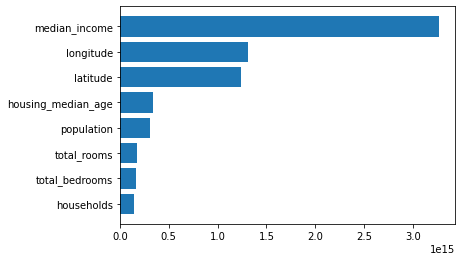

In [6]:
# 特徴量の重要度を可視化
plt.barh(importance.index[::-1], importance.importance[::-1])
plt.show()

#### __2値分類__

変更点

- `METRIC_NAME = 'auc'`

- `'objective': 'binary'`

In [7]:
# 評価指標
METRIC_NAME = 'auc'

# パラメータ
FOLDS = 5
SEED = 42
params = {
    'objective': 'binary', # 2値分類
    'metric': METRIC_NAME, # 評価指標
    'seed': 42,
    'num_leaves': 63,
    'learning_rate': 0.01,  # 学習率
    'feature_fraction': 0.8,
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
}

# データ
dataset = load_breast_cancer()
X, X_test, y, y_test = train_test_split(pd.DataFrame(dataset['data']), pd.Series(dataset['target']), train_size=0.8)

y_pred, results, models = lightgbm_cv(X, y, X_test, metric_name=METRIC_NAME, params=params, folds=FOLDS, seed=SEED, stratified=True)

Fold: 1  AUC: 0.9801020408163266
Fold: 2  AUC: 0.9923469387755102
Fold: 3  AUC: 0.9887755102040816
Fold: 4  AUC: 0.9551020408163265
Fold: 5  AUC: 0.9535714285714286
CV: 0.9739795918367345


#### __多クラス分類__

変更点

- `METRIC_NAME = 'multi_logloss'`

- `'objective': 'multiclass'`

- `'num_class': クラス数`

In [8]:
# 評価指標
METRIC_NAME = 'multi_logloss'

# パラメータ
FOLDS = 5
SEED = 42
params = {
    'objective': 'multiclass', # 多クラス分類
    'metric': METRIC_NAME, # 評価指標
    'seed': 42,
    'num_leaves': 63,
    'learning_rate': 0.01,  # 学習率
    'feature_fraction': 0.8,
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
    'num_class': len(load_iris()['target_names']), # クラス数を指定
}

# データ
dataset = load_iris()
X, X_test, y, y_test = train_test_split(pd.DataFrame(dataset['data']), pd.Series(dataset['target']), train_size=0.8)

y_pred, results, models = lightgbm_cv(X, y, X_test, metric_name=METRIC_NAME, params=params, folds=FOLDS, seed=SEED, stratified=True)

Fold: 1  MULTI_LOGLOSS: 0.14086765812274124
Fold: 2  MULTI_LOGLOSS: 0.20022091546385345
Fold: 3  MULTI_LOGLOSS: 0.02534238417680404
Fold: 4  MULTI_LOGLOSS: 0.14855622171687496
Fold: 5  MULTI_LOGLOSS: 0.11484364952184274
CV: 0.1259661658004233
